In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import os
import io
import boto3  # AWS

# from dash_functions import find_closest_poi

import json

from geopy.distance import geodesic
from geopy.geocoders import Nominatim

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold, validation_curve, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.svm import SVR

pd.set_option('display.max_columns', None)

In [2]:
# Load AWS Files
s3R = boto3.resource("s3")
s3 = boto3.client("s3")
bucket_name = "capstonehaystacks"

# Listing the contents of the S3 bucket to ensure everything looks good
for obj in s3R.Bucket(bucket_name).objects.all():
    print(obj.key)

GA_LISTINGS_SALES.csv
GA_LISTINGS_SALES_V2.csv
GA_listing.csv
all_zips_grocery_store.json
all_zips_restaurant.json
atlanta-geo.csv
atlanta_cbsa_zip.csv
atlanta_hdma_2021.csv
atlanta_hdma_census_2021.csv
atlanta_hdma_tract_2021.csv
atlanta_listings.csv
core_geo_dataset.csv
crime.csv
crime_rating_zipcode.csv
elementary_schools.csv
ga_georgia_zip_codes_geo.min.json
high_schools.csv
hmda_2017_ga_all-records_labels.csv
hmda_2021_ga_all-records_labels.csv
jason_listing.csv
listing-with-poi-distances.csv
listings_with_tract.csv
middle_schools.csv
poi_combined_haystack.csv
poi_combined_haystack_ALL.csv
poi_combined_haystack_ALL_CLEANED.csv
points-of-interest-google.csv
points-of-interest-google2.csv
points-of-interest-haystacks.csv
schools.csv
zip_summary.csv
zipcodes_111meter.min.json


In [3]:
file_name = "listing-with-poi-distances.csv"

file_obj = s3.get_object(Bucket=bucket_name, Key=file_name)
listings = pd.read_csv(file_obj["Body"])
print(listings.shape)
listings.head(3)

(7670, 52)


,latitude,longitude,full_street_address,city,county_name,beds,baths_full,baths_half,square_footage,lot_size,year_built,details,special_features,price,transaction_type,listing_status,listing_special_features,census_state_name,census_county_name,zip,GEOID,census_tract_number,airport_name,airport_miles,school_name,school_miles,worship_name,worship_miles,grocery_name,grocery_miles,restaurant_name,restaurant_miles,emergency_name,emergency_miles,public_trans_name,public_trans_miles,large_gatherings_name,large_gatherings_miles,shopping_name,shopping_miles,hospital_name,hospital_miles,public_inst_name,public_inst_miles,coffee_name,coffee_miles,bank_name,bank_miles,cars_name,cars_miles,park_name,park_miles
0,33.971863,-83.618736,633 Marigot Way,Statham,Barrow-County,3.0,2.0,0.0,1634.0,1.0,2004.0,"Detached, 3 Beds, 2 Baths, 1,634 Sq Ft",0,305000,1,1,0,Georgia,"Barrow, GA",30666,13013180401,13013180401,Big Canoe Heliport,50.81,Prince Ave Christian School,5.61,New Community Church,11.24,Quality Foods Inc.,5.72,Hot eSource,5.47,Gwinnett County Sheriff-Civil,21.55,Atlanta Peachtree Station,46.04,Lanier Islands,26.55,Boswell Electrical & Comm,5.77,Northeast Georgia Medical Center Barrow,5.69,Winder Public Library,6.26,Dunkin',6.00,Wells Fargo Bank,6.06,IAA Vehicle Purchasing,2.19,Fort Yargo State Park,6.39
1,34.018024,-83.663994,431 Dunahoo Road,Winder,Barrow-County,3.0,2.0,0.0,1625.0,0.0,1998.0,"Detached, 3 Beds, 2 Baths, 1,625 Sq Ft",0,349900,1,1,0,Georgia,"Barrow, GA",30680,13013180301,13013180301,Big Canoe Heliport,46.76,Winder-Barrow High School,3.79,New Community Church,7.15,Quality Foods Inc.,3.13,Camino Real,2.55,Gwinnett County Sheriff-Civil,19.45,Atlanta Peachtree Station,44.50,Lanier Islands,22.70,Walgreens,3.83,Northeast Georgia Medical Center Barrow,2.60,Winder Public Library,3.66,Dunkin',3.84,Wells Fargo Bank,3.86,Gazal Inc,2.93,Fort Yargo State Park,5.10
2,34.003227,-83.749001,471 Monticello Court,Winder,Barrow-County,4.0,3.0,0.0,1816.0,0.0,2001.0,"Detached, 4 Beds, 3 Baths, 1,816 Sq Ft",0,289900,1,1,0,Georgia,"Barrow, GA",30680,13013180303,13013180303,Big Canoe Heliport,43.87,Winder-Barrow High School,1.20,New Community Church,5.99,Walgreens,1.76,KFC,1.07,Gwinnett County Sheriff-Civil,14.47,Atlanta Peachtree Station,39.57,Lanier Islands,19.17,Tractor Supply Co.,0.85,Northeast Georgia Medical Center Barrow,2.39,Winder Public Library,1.52,Dunkin',1.87,Wells Fargo Bank,1.80,NAPA Auto Parts - Winder Auto Parts,1.74,Fort Yargo State Park,2.63


In [4]:
X = listings[['beds','baths_full', 'square_footage', 'lot_size', 'year_built', 'special_features',
          'airport_miles', 'school_miles', 'worship_miles', 'grocery_miles', 'restaurant_miles', 
          'emergency_miles', 'public_trans_miles', 'large_gatherings_miles', 'shopping_miles', 
         'hospital_miles', 'public_inst_miles', 'coffee_miles', 'bank_miles', 'cars_miles', 'park_miles']]
y = listings['price']

In [5]:
X.head(5)

,beds,baths_full,square_footage,lot_size,year_built,special_features,airport_miles,school_miles,worship_miles,grocery_miles,restaurant_miles,emergency_miles,public_trans_miles,large_gatherings_miles,shopping_miles,hospital_miles,public_inst_miles,coffee_miles,bank_miles,cars_miles,park_miles
0,3.0,2.0,1634.0,1.0,2004.0,0,50.81,5.61,11.24,5.72,5.47,21.55,46.04,26.55,5.77,5.69,6.26,6.00,6.06,2.19,6.39
1,3.0,2.0,1625.0,0.0,1998.0,0,46.76,3.79,7.15,3.13,2.55,19.45,44.50,22.70,3.83,2.60,3.66,3.84,3.86,2.93,5.10
2,4.0,3.0,1816.0,0.0,2001.0,0,43.87,1.20,5.99,1.76,1.07,14.47,39.57,19.17,0.85,2.39,1.52,1.87,1.80,1.74,2.63
3,3.0,2.0,1332.0,0.0,2014.0,0,42.94,0.52,8.08,4.42,1.13,12.41,36.79,20.75,0.81,5.86,4.76,1.23,4.38,4.56,3.13
4,3.0,2.0,1060.0,0.0,1999.0,0,46.08,1.52,7.10,0.55,0.30,16.87,41.81,21.55,1.09,0.89,1.10,1.07,1.10,0.46,2.38


In [6]:
y.head(5)

0    305000
1    349900
2    289900
3    310500
4    240000
Name: price, dtype: int64

# Model Selection

## Linear

In [7]:
listings_linear = listings.copy()

In [8]:
# Def function to Compute the correlation matrix

def corr_variables(df, thres):
    """
    Print highly correlated column pairs and their correlation coefficients from a DataFrame.

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing the variables to analyze.
        thres (float): The correlation threshold to consider. Only correlations greater than
                       the threshold will be considered.

    Returns:
        None

    Prints:
        Highly correlated columns and their correlation coefficients in descending order.

    Example:
        corr_variables(my_dataframe, 0.7)
    """
    corr_matrix = df.corr()

    # Extract only highly correlated columns
    threshold = thres
    highly_correlated_cols = corr_matrix[abs(corr_matrix) > threshold].stack().reset_index()
    highly_correlated_cols = highly_correlated_cols[
        highly_correlated_cols["level_0"] != highly_correlated_cols["level_1"]
    ]
    highly_correlated_cols = highly_correlated_cols.rename(columns={0: "correlation"})
    highly_correlated_cols["abs_correlation"] = highly_correlated_cols["correlation"].abs()
    highly_correlated_cols = highly_correlated_cols.sort_values(
        "abs_correlation", ascending=False
    )
    highly_correlated_cols = highly_correlated_cols.drop("abs_correlation", axis=1)

    # Print highly correlated columns with correlation coefficients
    for idx, row in highly_correlated_cols.iterrows():
        col1 = row["level_0"]
        col2 = row["level_1"]
        corr = row["correlation"]
        print(f"- {col1} & {col2}: {corr}")


In [9]:
X = listings[['beds','baths_full', 'square_footage', 'lot_size', 'year_built', 'special_features',
          'airport_miles', 'school_miles', 'worship_miles', 'grocery_miles', 'restaurant_miles', 
          'emergency_miles', 'public_trans_miles', 'large_gatherings_miles', 'shopping_miles', 
         'hospital_miles', 'public_inst_miles', 'coffee_miles', 'bank_miles', 'cars_miles', 'park_miles']]

corr_variables(X, thres=.75)

- baths_full & square_footage: 0.7930434958309072
- square_footage & baths_full: 0.7930434958309072
- beds & baths_full: 0.7596893881928192
- baths_full & beds: 0.7596893881928192
- grocery_miles & restaurant_miles: 0.7563838649887034
- restaurant_miles & grocery_miles: 0.7563838649887034
- grocery_miles & shopping_miles: 0.7500248205213336
- shopping_miles & grocery_miles: 0.7500248205213336


In [10]:
# - baths_full & square_footage: 0.7930434958309072       REMOVE: baths_full
# - square_footage & baths_full: 0.7930434958309072
# - beds & baths_full: 0.7596893881928192
# - baths_full & beds: 0.7596893881928192
# - grocery_miles & restaurant_miles: 0.7563838649887034
# - restaurant_miles & grocery_miles: 0.7563838649887034
# - grocery_miles & shopping_miles: 0.7500248205213336
# - shopping_miles & grocery_miles: 0.7500248205213336   REMOVE: grocery_miles

In [11]:
X = listings[['beds', 'square_footage', 'lot_size', 'year_built', 'special_features',
          'airport_miles', 'school_miles', 'worship_miles', 'restaurant_miles', 
          'emergency_miles', 'public_trans_miles', 'large_gatherings_miles', 'shopping_miles', 
         'hospital_miles', 'public_inst_miles', 'coffee_miles', 'bank_miles', 'cars_miles', 'park_miles']]

corr_variables(X, thres=.75)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, shuffle=True
)
print(X_train.shape)
print(X_test.shape)

(6136, 19)
(1534, 19)


In [13]:
# Define the linear regression model
lm = LinearRegression()

# Fit Model
lm.fit(X_train, y_train)

# Define the cross-validation scheme
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Calculate the R-squared score using cross-validation
scores = cross_val_score(lm, X_test, y_test, cv=cv, scoring="r2")

# Print the average R-squared score across all cross-validation folds
print(f"Average R-squared score: {scores.mean()}")

Average R-squared score: -3.597128030308827


### Ridge

In [14]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, shuffle=True
)
print(X_train.shape)
print(X_test.shape)

(6136, 19)
(1534, 19)


In [15]:
# Define the linear regression model
ridge = Ridge(alpha=1)

# Fit Model
ridge.fit(X_train, y_train)

# Define the cross-validation scheme
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Calculate the R-squared score using cross-validation
scores = cross_val_score(ridge, X_test, y_test, cv=cv, scoring="r2")

# Print the average R-squared score across all cross-validation folds
print(f"Average R-squared score: {scores.mean()}")

Average R-squared score: -3.5967904101504864


#### Optimizing Alpha

In [16]:
alphas = np.arange(0, 3)
coefs = []
scores = []
for alpha in alphas:
    ridge.set_params(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    scores.append(ridge.score(X_test, y_test))
coefs = pd.DataFrame(coefs, index=alphas, columns=X_train.columns)
coefs.head()

,beds,square_footage,lot_size,year_built,special_features,airport_miles,school_miles,worship_miles,restaurant_miles,emergency_miles,public_trans_miles,large_gatherings_miles,shopping_miles,hospital_miles,public_inst_miles,coffee_miles,bank_miles,cars_miles,park_miles
0,-80396.393500,357.683313,6.289701,-728.028948,-329.055574,-678.925697,3092.686420,8839.629491,8974.957194,5698.874046,-5646.649002,2784.227653,-7295.042435,52.485048,-2234.137572,8358.616408,-6156.077490,12253.969008,-2224.511289
1,-80378.798922,357.676202,6.289267,-728.079027,-329.056311,-679.005881,3092.667193,8839.493776,8973.864984,5698.877113,-5646.697958,2784.367137,-7294.269035,52.463739,-2233.743231,8358.992630,-6156.129266,12253.698617,-2224.703382
2,-80361.212092,357.669095,6.288832,-728.129082,-329.057048,-679.086015,3092.647925,8839.358020,8972.773169,5698.880157,-5646.746887,2784.506545,-7293.495712,52.442463,-2233.349024,8359.368634,-6156.181006,12253.428178,-2224.895358


Text(0, 0.5, 'slope values')

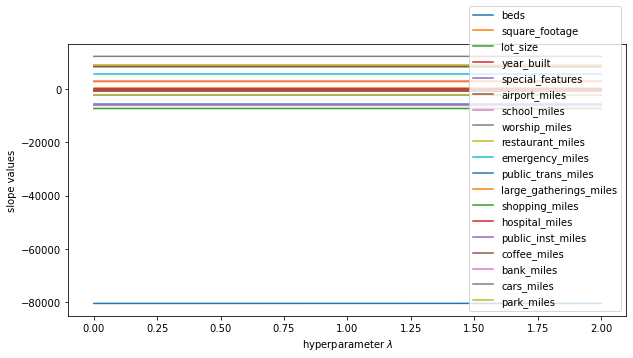

In [17]:
plt.rcParams["figure.figsize"] = (10, 5)
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)
plt.legend(loc=4)
plt.xlabel(r"hyperparameter $\lambda$")
plt.ylabel(r"slope values")

Text(0, 0.5, '$R^2$')

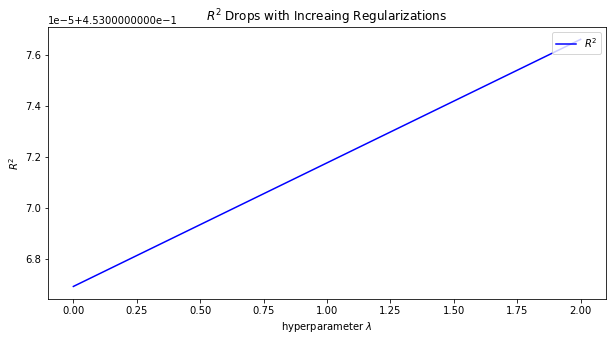

In [18]:
plt.plot(alphas, scores, c="b", label=r"$R^2$")
plt.legend(loc=1)
plt.title(r"$R^2$ Drops with Increaing Regularizations")
plt.xlabel(r"hyperparameter $\lambda$")
plt.ylabel(r"$R^2$")

## Random Forest

In [19]:
def r2mae_scores(model, X, y, cv=5):
    """
    Calculate R^2 and Mean Absolute Error (MAE) scores for the given model using cross-validation.
    
    Args:
        model: A scikit-learn model
        X: The feature matrix (numpy array or pandas DataFrame)
        y: The target variable (numpy array or pandas Series)
        cv: Number of folds for cross-validation (default: 5)

    Returns:
        avg_r2_score: The average R^2 score across the cross-validation folds
        avg_MAE_score: The average MAE score across the cross-validation folds
    """

    # Using R^2 as the scoring metric
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)

    # Using Mean Absolute Error as the scoring metric
    mae_scores = cross_val_score(
        model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
    )

    # Convert the MAE scores back to positive
    mae_scores = -1 * mae_scores

    avg_r2_score = np.mean(r2_scores)
    avg_MAE_score = np.mean(mae_scores)

    return avg_r2_score, avg_MAE_score


def print_scores(avg_r2_score, avg_MAE_score):
    """
    Print the average R^2 and MAE scores.

    Args:
        avg_r2_score: The average R^2 score
        avg_MAE_score: The average MAE score
    """
    print("-" * 50)
    print("5-fold Cross Validation Scoring")
    print("Average R^2 score:", avg_r2_score)
    print("Average MAE score:", avg_MAE_score)
    print("-" * 50)

In [20]:
model = RandomForestRegressor(random_state=0)
avg_r2_score, avg_MAE_score = r2mae_scores(model, X_train, y_train)
print_scores(avg_r2_score, avg_MAE_score)

--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.6850634125466054
Average MAE score: 168369.88561775122
--------------------------------------------------


## Feature Selection and Optimizing Number of Features
I'm creating four functions that will be used for feature selection and analysis: 
1.  The feature_importance function accepts a scikit-learn model (estimator), input data X, and target variable y. It fits the model on the provided data and then returns a sorted list of tuples containing the feature names and their respective importances, sorted in descending order of importance.
2. The r2_score_by_feature_count() function takes in a model, training and testing data, and returns a list of tuples with the number of features used and the mean R^2 score from 5-fold cross-validation. 
3. The plot_scores() takes in the output of r2_score_by_feature_count() and plots the feature count vs. R^2 score, with a vertical line indicating the optimal number of features.
4. The third function, plot_feature_importance(), takes in a model and the feature matrix for the training data, and plots a bar chart showing the top n_features important features for the given model based on the feature importances calculated from the training data. The function returns a sorted list of tuples containing the name of each feature and its importance score, sorted in descending order, as well as the DataFrame used for plotting the feature importance bar chart.

In [21]:
def feature_importance(model, X, y):
    """
    This function computes the feature importances of a given model, fitted on provided input data (X) and target variable (y).

    Args:
    model (sklearn estimator): The model for which feature importances will be computed.
    X (pd.DataFrame): The input features used for training the model.
    y (pd.Series, list or array-like): The target variable used for training the model.

    Returns:
    list: A sorted list of tuples containing the feature name and its importance, in descending order of importance.
    """
    model.fit(X, y)
    return sorted(
        zip(X.columns, model.feature_importances_), key=lambda t: t[1], reverse=True
    )


def r2_score_by_feature_count(model, X_train, y_train, X_test, y_test):
    """
    Calculates the R^2 score for a given model using a subset of the features in X_train and X_test.
    The R^2 score is calculated for each subset of features of increasing size.
    
    Args:
        model: A scikit-learn model
        X_train: The feature matrix for the training data (numpy array or pandas DataFrame)
        y_train: The target variable for the training data (numpy array or pandas Series)
        X_test: The feature matrix for the test data (numpy array or pandas DataFrame)
        y_test: The target variable for the test data (numpy array or pandas Series)

    Returns:
        A list of tuples containing the number of features used and the R^2 score for the given model.
    """
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features]

    scores = []
    for i in range(len(selected_columns)):
        X_train_subset = X_train[selected_columns[: i + 1]]
        X_test_subset = X_test[selected_columns[: i + 1]]

        model.fit(X_train_subset, y_train)
        score = cross_val_score(
            model, X_test_subset, y_test, cv=5, scoring="r2", n_jobs=-1
        )
        scores.append((i, np.mean(score)))

    return scores


def plot_scores(scores, vline_val):
    """
    Plots the R^2 score for a given model using a subset of the features in X_train and X_test.
    The R^2 score is calculated for each subset of features of increasing size.
    
    Args:
        scores: A list of tuples containing the number of features used and the R^2 score for the given model.
        vline_val: The optimal number of features, indicated by a vertical red line on the plot.
    """
    x_values = [t[0] for t in scores]
    y_values = [t[1] for t in scores]

    plt.plot(x_values, y_values)
    plt.axvline(x=vline_val, color="red", linestyle="--", alpha=0.4)

    plt.xlabel("# of Features")
    plt.ylabel("R^2 Performance")
    plt.title("Feature Selection")


    plt.show()
    
    
def plot_feature_importance(model, X_train, n_features=35):
    """
    Plots a bar chart showing the top n_features important features for the given model based on the feature importances
    calculated from X_train.
    
    Args:
        model: A scikit-learn model
        X_train: The feature matrix for the training data (numpy array or pandas DataFrame)
        n_features: The number of features to display on the plot (default: 35)

    Returns:
        sorted_importance: A sorted list of tuples containing the name of each feature and its importance score,
                           sorted in descending order.
        df: The DataFrame used for plotting the feature importance bar chart.
    """
    sorted_importance = sorted(
        zip(X_train.columns, model.feature_importances_),
        key=lambda t: t[1],
        reverse=True,
    )

    # Get data for the plot (n_features based on your preference)
    a, b = zip(*sorted_importance[:n_features])
    df = pd.DataFrame({"feature_name": a, "importance_score": b})

    # Plot

    plt.rcParams["figure.autolayout"] = True
    plt.subplots_adjust(bottom=0.15)

    plt.figure(figsize=(20, 10))
    df.plot.bar(x="feature_name", y="importance_score", legend=None)
    plt.title("Feature Importance")

   
    plt.show()

    return sorted_importance, df

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Fits a machine learning model to training data, makes predictions on both training and test sets, 
    and calculates performance metrics including mean squared error (MSE) and R^2 score.
    
    Parameters:
    -----------
    model : object
        An instance of a scikit-learn machine learning model.
    X_train : array-like
        The training data features.
    y_train : array-like
        The training data labels.
    X_test : array-like
        The test data features.
    y_test : array-like
        The test data labels.
        
    Returns:
    --------
    None
        Prints the training and test set performance metrics, including MSE and R^2 scores.
    """
    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the mean squared error for the train and test sets
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Calculate the R^2 for the train and test sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Print the performance metrics for the model on both the training and test sets
    print("The training error (MSE) is: %.5f" % mse_train)
    print("The test     error (MSE) is: %.5f" % mse_test)
    print("The training R^2 is: %.5f" % r2_train)
    print("The test     R^2 is: %.5f" % r2_test)


In [22]:
def find_best_params(X_train, y_train):
    """
    Find the best hyperparameters for a RandomForestRegressor using RandomizedSearchCV.

    Args:
    X_train: (pandas.DataFrame) Training features.
    y_train: (pandas.Series) Training target variable.

    Returns:
    best_params: (dict) Best hyperparameters found by RandomizedSearchCV.
    """

    param_grid = {
        "n_estimators": [10, 50, 100, 200],
        "max_depth": [10, 20, 30, 40, 50, 60],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [4, 8, 12],
        "max_features": ["auto", "sqrt"],
    }

    rf = RandomForestRegressor(random_state=0)
    randomized_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring="neg_mean_squared_error",
        random_state=0,
    )

    randomized_search.fit(X_train, y_train)

    return randomized_search.best_params_


In [23]:
def compare_models(model, X_train, y_train, X_test, y_test, optimal_features_count):
    """
    Trains and compares a machine learning model on all available features and on a subset of the most important features.
    
    Parameters:
    -----------
    model : object
        An instance of a scikit-learn machine learning model.
    X_train : array-like
        The training data features.
    y_train : array-like
        The training data labels.
    X_test : array-like
        The test data features.
    y_test : array-like
        The test data labels.
    optimal_features_count : int
        The number of top features to select for training the model.
        
    Returns:
    --------
    tuple
        A tuple of two floats representing the model's performance scores on the test data, 
        first using all available features and second using the subset of the most important features.
    """
    # Train and test the model on all available features
    model.fit(X_train, y_train)
    all_features_score = model.score(X_test, y_test)

    # Train and test the model on a subset of the most important features
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features][:optimal_features_count]

    X_train_optimal = X_train[selected_columns]
    X_test_optimal = X_test[selected_columns]

    model.fit(X_train_optimal, y_train)
    optimal_features_score = model.score(X_test_optimal, y_test)

    # Return the model's performance scores
    return all_features_score, optimal_features_score

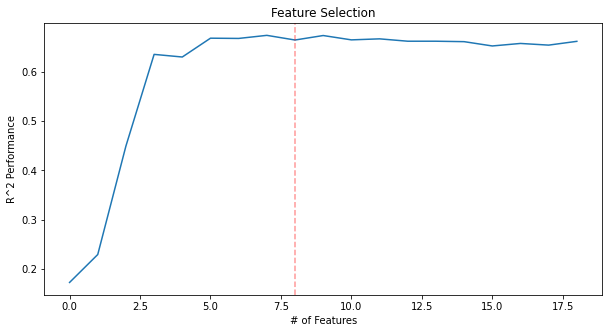

In [24]:
# Running the functions and viewing the plot of feature importance
model = RandomForestRegressor(random_state=0)
scores = r2_score_by_feature_count(model, X_train, y_train, X_test, y_test)
plot_scores(scores=scores, vline_val=8)

In [25]:
# Creating Random Forest Regression model and fitting the feature martix
# and target variable
random_forest_model = RandomForestRegressor(random_state=0)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

<Figure size 720x360 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

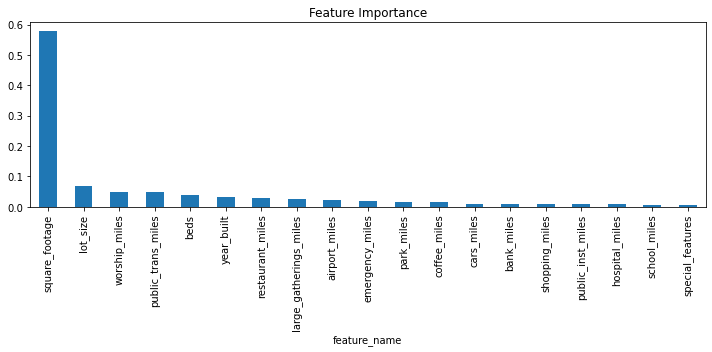

([('square_footage', 0.578181873616056),
  ('lot_size', 0.06818813886346028),
  ('worship_miles', 0.0483140788549033),
  ('public_trans_miles', 0.04767283394392435),
  ('beds', 0.03795701462433506),
  ('year_built', 0.03134092497493581),
  ('restaurant_miles', 0.028999455686252135),
  ('large_gatherings_miles', 0.02411529241835776),
  ('airport_miles', 0.022670123548311525),
  ('emergency_miles', 0.01857012100921536),
  ('park_miles', 0.0159906152910289),
  ('coffee_miles', 0.015347771854311512),
  ('cars_miles', 0.010736662551603873),
  ('bank_miles', 0.010559133242852462),
  ('shopping_miles', 0.010214295718150291),
  ('public_inst_miles', 0.009877180842864985),
  ('hospital_miles', 0.00936051739041183),
  ('school_miles', 0.007351774987061731),
  ('special_features', 0.0045521905819627066)],
               feature_name  importance_score
 0           square_footage          0.578182
 1                 lot_size          0.068188
 2            worship_miles          0.048314
 3       p

In [26]:
# Using function created earlier to plot and save feature importance
plot_feature_importance(random_forest_model, X_train, n_features=20)

## Comparing Models of Optimal Features Vs All Features

In [27]:
# Initializing random forest regression model
model = RandomForestRegressor(random_state=0)

# Setting the number of optimal features
optimal_features_count = 8

# Training and comparing the model's performance with optimal vs all features
all_features_score, optimal_features_score = compare_models(model, X_train, y_train, X_test, y_test, optimal_features_count)

# Printing the model's performance scores
print("R^2 score using all features: ", all_features_score)
print("R^2 score using optimal features: ", optimal_features_score)

R^2 score using all features:  0.6179965491097791
R^2 score using optimal features:  0.6242708693625763


In [28]:
# Using the find_best_params function to find the best hyperparameters
best_params = find_best_params(X_train, y_train)
print("Best parameters found by RandomizedSearchCV:")
print(best_params)

# Creating a RandomForestRegressor using the best hyperparameters and evaluating it
best_rf = RandomForestRegressor(**best_params, random_state=0)
evaluate_model(best_rf, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found by RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40}
The training error (MSE) is: 136004730714.14334
The test     error (MSE) is: 106829759575.37440
The training R^2 is: 0.80034
The test     R^2 is: 0.75641


In [29]:
# Defining the grid of hyperparameters to search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [40, 50, 60],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [4, 8, 12],
    "max_features": ["auto", "sqrt"],
}
# Initializing RandomRegressor
rf = RandomForestRegressor(random_state=0)
best_rf_GS = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring="neg_mean_squared_error",
    random_state=0,
)
# Fitting to trainning data
best_rf_GS.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [40, 50, 60],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 8, 12],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=0, scoring='neg_mean_squared_error', verbose=2)